In [2]:
from matplotlib import pyplot as plt 
import scipy as sp

import numpy as np

import NAFFlib
import json
import xtrack as xt
import xpart as xp
import xobjects as xo 

from scipy.constants import c as speed_c
from scipy.constants import e as qe
from scipy.constants import m_p
import pandas as pd
import sys
import math
import xdeps as xd
from xdeps.madxutils import MadxEval
import conda
import time



def generate_coordGrid(xRange,yRange,labels = ['x','y'],nPoints=100):
    '''
    
    Temporary function from BBfootprint change to BBfootprint installation after Philippe has implemented it 
    
    Distribute points uniformly on a 2D grid.
    -----------------------------------------
    Input:
        xRange : range of first coordinate
        yRange : range of second coordinate
        labels : labels to be used in the resulting dataframe
        nPoint : total number of points to generate (sqrt(nPoints) for each coordinate)
    Returns:
        coordinates: dataframe containing the distributed points
    '''

    if type(xRange) is list and type(yRange) is list:
        xVec = np.linspace(xRange[0],xRange[1],int(np.sqrt(nPoints)))
        yVec = np.linspace(yRange[0],yRange[1],int(np.sqrt(nPoints)))
    else:
        xVec = xRange
        yVec = yRange
        
    xx,yy = np.meshgrid(xVec,yVec)
    xx,yy = xx.flatten(),yy.flatten()

    return pd.DataFrame(dict(zip(labels,[xx,yy])))




In [3]:

# load the line 


with open('../Examples/xtrack_release20_bb.json', 'r') as fid: # tune further from diagonal no bb
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)

line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1,
                        gamma0=6800/0.938)
part_ref = line.particle_ref 

context = xo.ContextCupy()         # For GPU





Done loading line from dict.           


In [4]:
tracker=line.build_tracker()

generating ./ec623f26c4894b9ebf9761788a0244b3.c
the current directory is '/home/elamb/xsuite_functions/xsuite_functions'
running build_ext
building 'ec623f26c4894b9ebf9761788a0244b3' extension
gcc -pthread -B /home/elamb/clean/executable/py_29_02_22/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/elamb/clean/executable/py_29_02_22/miniconda/include -I/home/elamb/clean/executable/py_29_02_22/miniconda/include -fPIC -O2 -isystem /home/elamb/clean/executable/py_29_02_22/miniconda/include -fPIC -I/home/elamb/clean/executable/py_29_02_22/miniconda/include/python3.9 -c ec623f26c4894b9ebf9761788a0244b3.c -o ./ec623f26c4894b9ebf9761788a0244b3.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/elamb/clean/executable/py_29_02_22/miniconda/compiler_compat -shared -Wl,-rpath,/home/elamb/clean/executable/py_29_02_22/miniconda/lib -Wl,-rpath-link,/home/elamb/clean/executable/py_29_02_22/miniconda/lib -L/home/elamb/clean/executable/py_29_

In [ ]:
beam = 'b1'
# Deactivating all wires
#===================================================
tracker.vars['enable_qff'] = 0
for IP in ['ip1','ip5']:
    tracker.vars[f"bbcw_rw_{IP}.{beam}"] = 1
    tracker.vars[f"bbcw_i_{IP}.{beam}"]  = 0

    
# Creating BB knobs
#===================================================
allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())


for _ip in ['ip1','ip5','ip2','ip8']:
    bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}b1' in name)]
    bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}b1' in name)]

    # New knob:
    tracker.vars[f'{_ip}_bblr_ON'] = 1
    tracker.vars[f'{_ip}_bbho_ON'] = 1

    # Linking to new knob
    for _lr in bb_lr:
        tracker.element_refs[_lr].n_particles      = tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].n_particles._value
    for _ho in bb_ho:
        tracker.element_refs[_ho].slices_other_beam_num_particles = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].slices_other_beam_num_particles._value[0]

# Creating sext and oct knobs
#====================================================
ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON'] = 1
for _ks in ks:
    if tracker.vars[_ks]._expr is None:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
    else:
        tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
for _ko in ko:
    if tracker.vars[_ko]._expr is None:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
    else:
        tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

In [5]:
print('\nInitial twiss parameters')
tw_before = tracker.twiss()
print(f"Qx = {tw_before['qx']:.5f} Qy = {tw_before['qy']:.5f} "
      f"Q'x = {tw_before['dqx']:.5f} Q'y = {tw_before['dqy']:.5f}")


Initial twiss parameters
Qx = 62.28963 Qy = 60.30240 Q'x = 14.45716 Q'y = 15.46175


In [9]:
allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())

[name for name in allVars if ('oct' in name)]

['all_oct_ON']

In [10]:
tracker.['on_bb_charge']._info()

SyntaxError: invalid syntax (1521255166.py, line 1)

In [11]:
tracker.vars[f'ip1_bbho_ON'] = 1
tracker.vars[f'ip2_bbho_ON'] = 1
tracker.vars[f'ip5_bbho_ON'] = 1
tracker.vars[f'ip8_bbho_ON'] = 1


tracker.vars[f'ip1_bbho_ON']._value







1

In [12]:
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip2_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0
tracker.vars[f'ip8_bbho_ON'] = 0

In [13]:

# have to turn off beambeam before you rematch 



# rematch using the xtrack.tracker.match 


t1 = time.time()


tracker.match(vary=['dqx.b1','dqy.b1','dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('qx', 62.31),
        ('qy',60.32),
        ('dqx', 15.0),
        ('dqy', 15.0),])
              
              
t2 = time.time()

print('\nTime fsolve: ', t2-t1)

tw_final = tracker.twiss()
print('\nFinal twiss parameters bb OFF ')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")


Time fsolve:  25.761637687683105

Final twiss parameters bb OFF 
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00000 Q'y = 15.00000


In [14]:
# turn back on the beam-beam



tracker.vars[f'ip1_bbho_ON'] = 1
tracker.vars[f'ip2_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0
tracker.vars[f'ip8_bbho_ON'] = 0


In [15]:
# after turning the bb at IP 5 back on 


tw_final = tracker.twiss()
print('\nFinal twiss parameters bb ON')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")


Final twiss parameters bb ON
Qx = 62.30098 Qy = 60.31102 Q'x = 14.66002 Q'y = 15.36362


In [ ]:
tracker.vars['all_oct_ON']  = 1
tracker.vars['all_sext_ON']  = 1

In [ ]:
tracker.vars['all_oct_ON']  = 0
tracker.vars['all_sext_ON']  = 0

In [96]:
coordinates = generate_coordGrid(np.linspace(0.1,8,40),
                                    np.linspace(0.06*np.pi/2,0.92*np.pi/2,60),labels = ['r_n','theta_n'])

coordinates.insert(0,'x_n',coordinates['r_n']*np.cos(coordinates['theta_n']))
coordinates.insert(1,'y_n',coordinates['r_n']*np.sin(coordinates['theta_n']))

x_n = np.array(coordinates['x_n'])
y_n = np.array(coordinates['y_n'])

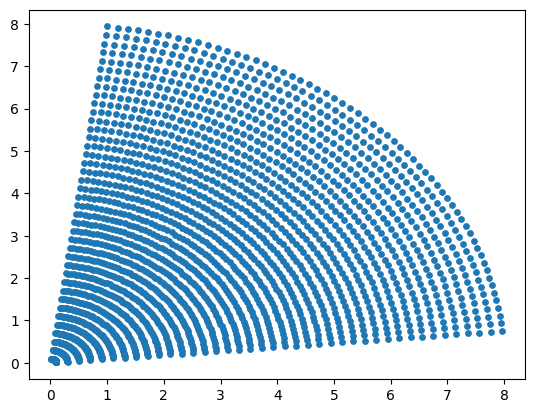

In [97]:
plt.scatter(x_n,y_n, s=points)
plt.grid()
plt.label('Initial distribution')

In [1]:
coordinates

NameError: name 'coordinates' is not defined

In [98]:

context = xo.ContextCupy()    


particles = xp.build_particles(_context=context,
                               tracker=tracker, particle_ref=part_ref,
                               zeta=0, delta=0,
                               x_norm=x_n, # in sigmas
                               y_norm=y_n, # in sigmas
                               scale_with_transverse_norm_emitt=(2.5e-06, 2.5e-06)
                               )

tracker.track(particles, num_turns=1024,turn_by_turn_monitor=True); # track for a longer number of turns?



KeyboardInterrupt: 

In [23]:
def get_max_tune(tracker, tune_maxima=5):
    
    h = tune_maxima # find 6 maxima along the spectrum 


    q_x = []
    for k in range(len(x_n)):
        naff_tune = NAFFlib.get_tunes_all(tracker.record_last_track.x[k].copy(),h)
        amp = []
        for i in range(h):

            amp.append(np.abs(naff_tune[1][i]))

        for i in range(h):      
            if amp[i]==np.max(amp):
                q_x.append(np.abs(naff_tune[0][i]))

    q_y = []
    for k in range(len(y_n)):
        naff_tune = NAFFlib.get_tunes_all(tracker.record_last_track.y[k].copy(),h)
        amp = []
        for i in range(h):
            amp.append(np.abs(np.abs(naff_tune[1][i])))

        for i in range(h):        
            if amp[i]==np.max(amp):
                q_y.append(np.abs(naff_tune[0][i]))
                
    return q_x, q_y

In [24]:
# plot the footprint 


def plot_footprint(qx,qy,coords_per_arc,no_arcs,title=str,):
    plot_object = plt.figure('FOOTPRINT')
    plt.suptitle(title)
    
    n = coords_per_arc
    m = no_arcs
    points=8

    plt.scatter(q_x[0:n],q_y[0:n], label = '0.3 $\sigma$ ', s=points)
    plt.scatter(q_x[n:2*n],q_y[n:2*n], label = '1.0 $\sigma$ ',s=points)
    plt.scatter(q_x[2*n:3*n],q_y[2*n:3*n], label = '2.0 $\sigma$ ',s=points)
    plt.scatter(q_x[3*n:4*n],q_y[3*n:4*n], label = '3.0 $\sigma$', s=points)
    plt.scatter(q_x[4*n:5*n],q_y[4*n:5*n], label = '4.0 $\sigma$ ', s=points)
    plt.scatter(q_x[5*n:6*n],q_y[5*n:6*n], label = '5.0 $\sigma$ ', s=points)
    plt.scatter(q_x[6*n:7*n],q_y[6*n:7*n], label = '6.0 $\sigma$ ', s=points)

    for i in range(n):
        q_x_s1c = [q_x[0+i],q_x[n+i],q_x[2*n+i],q_x[3*n+i],q_x[4*n+i],q_x[5*n+i],q_x[6*n+i]]
        q_y_s1c = [q_y[0+i],q_y[n+i],q_y[2*n+i],q_y[3*n+i],q_y[4*n+i],q_y[5*n+i],q_y[6*n+i]]
        plt.plot(q_x_s1c,q_y_s1c,'darkgrey')



    plt.plot(q_x[0:n-1],q_y[0:n-1],color='darkgrey',)
    plt.plot(q_x[n:2*n-1],q_y[n:2*n-1],color='darkgrey',)
    plt.plot(q_x[2*n:3*n-1],q_y[2*n:3*n-1], color='darkgrey',)
    plt.plot(q_x[3*n:4*n-1],q_y[3*n:4*n-1], color='darkgrey',)
    plt.plot(q_x[4*n:5*n-1],q_y[4*n:5*n-1], color='darkgrey',)
    plt.plot(q_x[5*n:6*n-1],q_y[5*n:6*n-1],color='darkgrey',)
    plt.plot(q_x[6*n:7*n],q_y[6*n:7*n], color='darkgrey',)


    plt.ylabel('$Q_y$')
    plt.xlabel('$Q_x$')

    plt.tight_layout()
    plt.axis('equal');
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()

    



In [73]:
def plot_footprint(qx,qy,coords_per_arc,no_arcs,title=str,):
    plot_object = plt.figure('FOOTPRINT')
    plt.suptitle(title)
    
    n = coords_per_arc
    m = no_arcs
    points=8
    plt.scatter(q_x[0:n],q_y[0:n],  s=points, color='r')
    
    for i in range(m+1):
        plt.scatter(q_x[(i+1)*n:(i+2)*n],q_y[(i+1)*n:(i+2)*n],s=points, color='r')
        plt.plot(q_x[i*n:(i+1)*n-1],q_y[i*n:(i+1)*n-1],color='darkgrey',)
        
        
        print(i)
        
    plt.plot(q_x[(m)*n:(m+1)*n],q_y[(m)*n:(m+1)*n],color='darkgrey',)

        

    for i in range(n):
        q_x_s1c = [q_x[0+i],q_x[n+i],q_x[2*n+i],q_x[3*n+i],q_x[4*n+i],q_x[5*n+i],q_x[6*n+i]]
        q_y_s1c = [q_y[0+i],q_y[n+i],q_y[2*n+i],q_y[3*n+i],q_y[4*n+i],q_y[5*n+i],q_y[6*n+i]]
        plt.plot(q_x_s1c,q_y_s1c,'darkgrey')

    '''

    '''

    plt.ylabel('$Q_y$')
    plt.xlabel('$Q_x$')

    plt.tight_layout()
    plt.axis('equal');
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
1
2
3
4
5
6
7


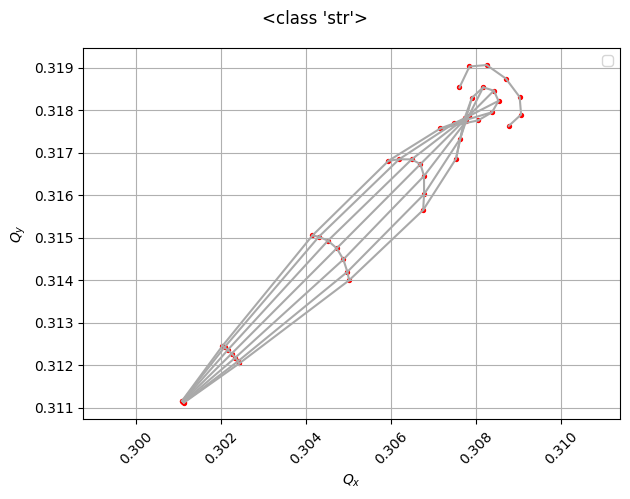

In [74]:

plot_footprint(q_x,q_y,7,7)

# octupole is off 

In [82]:

#plt.plot(q_x[0:n-1],q_y[0:n-1],color='darkgrey',)
#plt.plot(q_x[n:2*n-1],q_y[n:2*n-1],color='darkgrey',)
#plt.plot(q_x[2*n:3*n-1],q_y[2*n:3*n-1], color='darkgrey',)
#plt.plot(q_x[3*n:4*n-1],q_y[3*n:4*n-1], color='darkgrey',)
#plt.plot(q_x[4*n:5*n-1],q_y[4*n:5*n-1], color='darkgrey',)
#plt.plot(q_x[5*n:6*n-1],q_y[5*n:6*n-1],color='darkgrey',)
#plt.plot(q_x[6*n:7*n],q_y[6*n:7*n], color='darkgrey',)

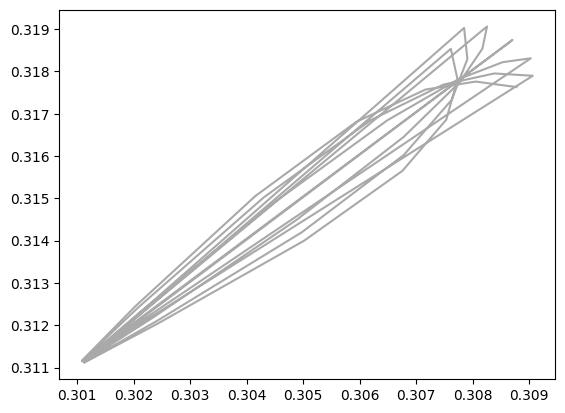

In [83]:
plt.plot(q_x[0:n-1],q_y[0:n-1],color='darkgrey',)


In [86]:
q_x
x_n

array([0.29866859, 0.99556196, 1.99112393, 2.98668589, 3.98224786,
       4.97780982, 5.97337179, 0.28482764, 0.94942548, 1.89885096,
       2.84827643, 3.79770191, 4.74712739, 5.69655287, 0.25660928,
       0.85536426, 1.71072852, 2.56609278, 3.42145704, 4.2768213 ,
       5.13218556, 0.21543789, 0.7181263 , 1.4362526 , 2.15437889,
       2.87250519, 3.59063149, 4.30875779, 0.16339171, 0.54463904,
       1.08927807, 1.63391711, 2.17855614, 2.72319518, 3.26783421,
       0.10309791, 0.34365969, 0.68731939, 1.03097908, 1.37463878,
       1.71829847, 2.06195817, 0.03759997, 0.12533323, 0.25066647,
       0.3759997 , 0.50133293, 0.62666617, 0.7519994 ])

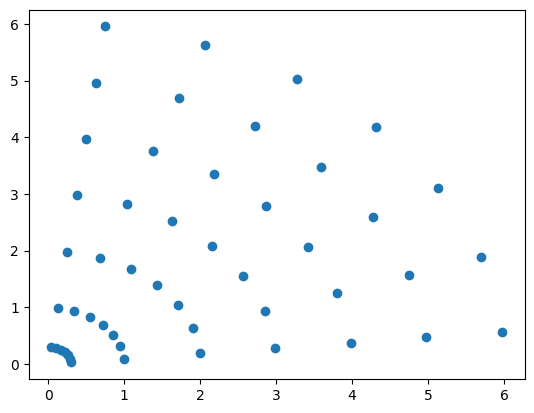

In [88]:
plt.scatter(x_n,y_n)